In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

print(keras.__version__)

2023-06-10 10:50:40.780752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
2.11.0
2.11.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('adult.data', sep=", ",header = None)
test_set = pd.read_csv('adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()


/var/folders/zy/jl2rn8kj7cx0g35_dvq0zksh0000gn/T/ipykernel_43940/1127659990.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_set = pd.read_csv('adult.data', sep=", ",header = None)
/var/folders/zy/jl2rn8kj7cx0g35_dvq0zksh0000gn/T/ipykernel_43940/1127659990.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_set = pd.read_csv('adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Zad.
Zróbmy szybki preprocesing

In [4]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class


X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

In [5]:
from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import History

history = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4200      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________


2023-06-10 10:51:12.494130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
model.compile(loss="binary_crossentropy",optimizer="Adam", metrics=["accuracy"])

# Zad
nauczmy model z EarlyStopping

Musimy podać:
* miarę, która ma zostać użyta do zatrzymania modelu
* jak długo ma model ma czekać na otrzymanie lepszego parametru zanim się zatrzyma


In [7]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
history = model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[early_stopping])

Epoch 1/100
943/943 [==============================] - 1s 1ms/step - loss: 0.4440 - accuracy: 0.7886 - val_loss: 0.3955 - val_accuracy: 0.7918
Epoch 2/100
943/943 [==============================] - 1s 917us/step - loss: 0.3805 - accuracy: 0.8101 - val_loss: 0.3714 - val_accuracy: 0.8153
Epoch 3/100
943/943 [==============================] - 1s 912us/step - loss: 0.3754 - accuracy: 0.8120 - val_loss: 0.3754 - val_accuracy: 0.8147
Epoch 4/100
943/943 [==============================] - 1s 911us/step - loss: 0.3718 - accuracy: 0.8137 - val_loss: 0.3568 - val_accuracy: 0.8341
Epoch 5/100
943/943 [==============================] - 1s 920us/step - loss: 0.3651 - accuracy: 0.8201 - val_loss: 0.3606 - val_accuracy: 0.8326
Epoch 6/100
943/943 [==============================] - 1s 931us/step - loss: 0.3662 - accuracy: 0.8187 - val_loss: 0.3679 - val_accuracy: 0.8271
Epoch 7/100
943/943 [==============================] - 1s 928us/step - loss: 0.3672 - accuracy: 0.8176 - val_loss: 0.3646 - val_accu

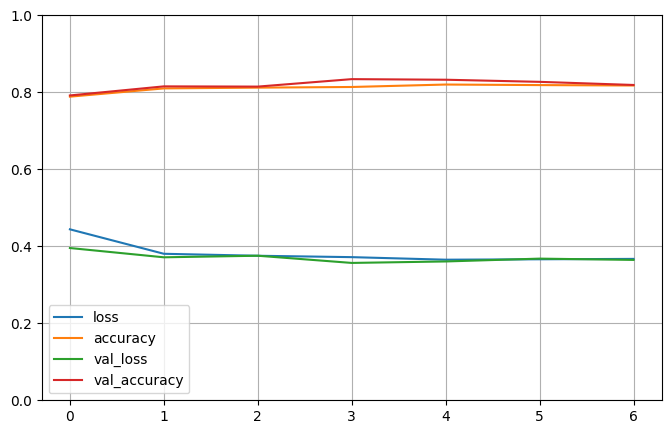

In [8]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [9]:
model.evaluate(X_test,y_test)

471/471 [==============================] - 0s 514us/step - loss: 0.3646 - accuracy: 0.8190


[0.3645767867565155, 0.8189907073974609]

In [11]:
from sklearn import  metrics
metrics.accuracy_score(y_true= y_test, y_pred = np.argmax(model.predict(X_test),axis=1))

471/471 [==============================] - 0s 423us/step


0.7543160690571049

# Zad.
Na poniższych danych naucz

* model bez EarlyStopping z 1000 epok
* model z wykorzystaniem EarlyStopping 
    dobierz paametr
    ```python
    patience=
    ```

Zwizualizuj wyniki:

* porównaj krzywe uczenia
* narysuj granice decyzyjne (dane są w 2D)




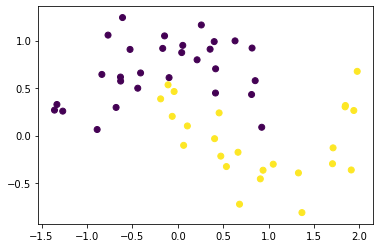

In [5]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [14]:
# model bez early stopping - 1000 epoch

from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import History
from keras.callbacks import EarlyStopping

keras.backend.clear_session()

history_NO_EARLY_STOPPING = History()
model_NO_EARLY_STOPPING = Sequential()
model_NO_EARLY_STOPPING.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model_NO_EARLY_STOPPING.add(Dense(50,activation="sigmoid"))
model_NO_EARLY_STOPPING.add(Dense(10,activation="sigmoid"))
model_NO_EARLY_STOPPING.add(Dense(1,activation="sigmoid"))
model_NO_EARLY_STOPPING.summary()

model_NO_EARLY_STOPPING.compile(loss="binary_crossentropy",optimizer="Adam", metrics=["accuracy"])

history_NO_EARLY_STOPPING = model_NO_EARLY_STOPPING.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=1000)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4200      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
943/943 [==============================] - 1s 1ms/step - loss: 0.4544 - accuracy: 0.7865 - val_loss: 0.3865 - val_accuracy: 0.8133
Epoch 2/1000
943/943 [====================

Epoch 106/1000
943/943 [==============================] - 1s 971us/step - loss: 0.3564 - accuracy: 0.8187 - val_loss: 0.3646 - val_accuracy: 0.8175
Epoch 107/1000
943/943 [==============================] - 1s 949us/step - loss: 0.3554 - accuracy: 0.8174 - val_loss: 0.3687 - val_accuracy: 0.8127
Epoch 108/1000
943/943 [==============================] - 1s 967us/step - loss: 0.3547 - accuracy: 0.8197 - val_loss: 0.3627 - val_accuracy: 0.8137
Epoch 109/1000
943/943 [==============================] - 1s 1ms/step - loss: 0.3543 - accuracy: 0.8196 - val_loss: 0.3632 - val_accuracy: 0.8186
Epoch 110/1000
943/943 [==============================] - 1s 989us/step - loss: 0.3545 - accuracy: 0.8198 - val_loss: 0.3648 - val_accuracy: 0.8180
Epoch 111/1000
943/943 [==============================] - 1s 951us/step - loss: 0.3546 - accuracy: 0.8210 - val_loss: 0.3640 - val_accuracy: 0.8150
Epoch 112/1000
943/943 [==============================] - 1s 932us/step - loss: 0.3536 - accuracy: 0.8200 - val_lo

943/943 [==============================] - 1s 921us/step - loss: 0.3581 - accuracy: 0.8190 - val_loss: 0.3693 - val_accuracy: 0.8096
Epoch 217/1000
943/943 [==============================] - 1s 925us/step - loss: 0.3518 - accuracy: 0.8201 - val_loss: 0.3722 - val_accuracy: 0.8135
Epoch 218/1000
943/943 [==============================] - 1s 921us/step - loss: 0.3490 - accuracy: 0.8202 - val_loss: 0.3685 - val_accuracy: 0.8092
Epoch 219/1000
943/943 [==============================] - 1s 922us/step - loss: 0.3482 - accuracy: 0.8227 - val_loss: 0.3688 - val_accuracy: 0.8141
Epoch 220/1000
943/943 [==============================] - 1s 921us/step - loss: 0.3516 - accuracy: 0.8194 - val_loss: 0.3677 - val_accuracy: 0.8161
Epoch 221/1000
943/943 [==============================] - 1s 921us/step - loss: 0.3505 - accuracy: 0.8210 - val_loss: 0.3689 - val_accuracy: 0.7938
Epoch 222/1000
943/943 [==============================] - 1s 920us/step - loss: 0.3496 - accuracy: 0.8225 - val_loss: 0.3682 - 

943/943 [==============================] - 1s 918us/step - loss: 0.3485 - accuracy: 0.8233 - val_loss: 0.3703 - val_accuracy: 0.8158
Epoch 327/1000
943/943 [==============================] - 1s 919us/step - loss: 0.3486 - accuracy: 0.8230 - val_loss: 0.3786 - val_accuracy: 0.8057
Epoch 328/1000
943/943 [==============================] - 1s 918us/step - loss: 0.3513 - accuracy: 0.8206 - val_loss: 0.3735 - val_accuracy: 0.8120
Epoch 329/1000
943/943 [==============================] - 1s 918us/step - loss: 0.3510 - accuracy: 0.8228 - val_loss: 0.3736 - val_accuracy: 0.7928
Epoch 330/1000
943/943 [==============================] - 1s 919us/step - loss: 0.3514 - accuracy: 0.8211 - val_loss: 0.3732 - val_accuracy: 0.8141
Epoch 331/1000
943/943 [==============================] - 1s 919us/step - loss: 0.3524 - accuracy: 0.8197 - val_loss: 0.3813 - val_accuracy: 0.8122
Epoch 332/1000
943/943 [==============================] - 1s 919us/step - loss: 0.3494 - accuracy: 0.8227 - val_loss: 0.3718 - 

943/943 [==============================] - 1s 923us/step - loss: 0.3473 - accuracy: 0.8237 - val_loss: 0.3697 - val_accuracy: 0.8157
Epoch 437/1000
943/943 [==============================] - 1s 926us/step - loss: 0.3460 - accuracy: 0.8240 - val_loss: 0.3748 - val_accuracy: 0.8111
Epoch 438/1000
943/943 [==============================] - 1s 954us/step - loss: 0.3465 - accuracy: 0.8238 - val_loss: 0.3718 - val_accuracy: 0.8158
Epoch 439/1000
943/943 [==============================] - 1s 922us/step - loss: 0.3616 - accuracy: 0.8158 - val_loss: 0.3792 - val_accuracy: 0.8138
Epoch 440/1000
943/943 [==============================] - 1s 976us/step - loss: 0.3509 - accuracy: 0.8214 - val_loss: 0.3752 - val_accuracy: 0.8137
Epoch 441/1000
943/943 [==============================] - 1s 927us/step - loss: 0.3483 - accuracy: 0.8216 - val_loss: 0.3727 - val_accuracy: 0.8143
Epoch 442/1000
943/943 [==============================] - 1s 931us/step - loss: 0.3562 - accuracy: 0.8189 - val_loss: 0.3754 - 

Epoch 547/1000
943/943 [==============================] - 1s 920us/step - loss: 0.3374 - accuracy: 0.8329 - val_loss: 0.3646 - val_accuracy: 0.8339
Epoch 548/1000
943/943 [==============================] - 1s 920us/step - loss: 0.3343 - accuracy: 0.8368 - val_loss: 0.3744 - val_accuracy: 0.8191
Epoch 549/1000
943/943 [==============================] - 1s 919us/step - loss: 0.3338 - accuracy: 0.8364 - val_loss: 0.3898 - val_accuracy: 0.8175
Epoch 550/1000
943/943 [==============================] - 1s 930us/step - loss: 0.3294 - accuracy: 0.8386 - val_loss: 0.3609 - val_accuracy: 0.8308
Epoch 551/1000
943/943 [==============================] - 1s 919us/step - loss: 0.3291 - accuracy: 0.8398 - val_loss: 0.3884 - val_accuracy: 0.8017
Epoch 552/1000
943/943 [==============================] - 1s 918us/step - loss: 0.3293 - accuracy: 0.8419 - val_loss: 0.3646 - val_accuracy: 0.8267
Epoch 553/1000
943/943 [==============================] - 1s 934us/step - loss: 0.3271 - accuracy: 0.8407 - val_

943/943 [==============================] - 1s 931us/step - loss: 0.3451 - accuracy: 0.8238 - val_loss: 0.3802 - val_accuracy: 0.8143
Epoch 658/1000
943/943 [==============================] - 1s 927us/step - loss: 0.3424 - accuracy: 0.8253 - val_loss: 0.3792 - val_accuracy: 0.8132
Epoch 659/1000
943/943 [==============================] - 1s 920us/step - loss: 0.3439 - accuracy: 0.8241 - val_loss: 0.3818 - val_accuracy: 0.8115
Epoch 660/1000
943/943 [==============================] - 1s 923us/step - loss: 0.3560 - accuracy: 0.8205 - val_loss: 0.3856 - val_accuracy: 0.8098
Epoch 661/1000
943/943 [==============================] - 1s 924us/step - loss: 0.3470 - accuracy: 0.8234 - val_loss: 0.3797 - val_accuracy: 0.8112
Epoch 662/1000
943/943 [==============================] - 1s 918us/step - loss: 0.3440 - accuracy: 0.8241 - val_loss: 0.3841 - val_accuracy: 0.8152
Epoch 663/1000
943/943 [==============================] - 1s 921us/step - loss: 0.3434 - accuracy: 0.8239 - val_loss: 0.3811 - 

943/943 [==============================] - 1s 1ms/step - loss: 0.3510 - accuracy: 0.8222 - val_loss: 0.3816 - val_accuracy: 0.8118
Epoch 768/1000
943/943 [==============================] - 1s 960us/step - loss: 0.3446 - accuracy: 0.8238 - val_loss: 0.3774 - val_accuracy: 0.8139
Epoch 769/1000
943/943 [==============================] - 1s 940us/step - loss: 0.3497 - accuracy: 0.8232 - val_loss: 0.3816 - val_accuracy: 0.8138
Epoch 770/1000
943/943 [==============================] - 1s 1ms/step - loss: 0.3428 - accuracy: 0.8244 - val_loss: 0.3768 - val_accuracy: 0.8143
Epoch 771/1000
943/943 [==============================] - 1s 928us/step - loss: 0.3428 - accuracy: 0.8245 - val_loss: 0.3793 - val_accuracy: 0.8131
Epoch 772/1000
943/943 [==============================] - 1s 930us/step - loss: 0.3433 - accuracy: 0.8241 - val_loss: 0.3777 - val_accuracy: 0.8110
Epoch 773/1000
943/943 [==============================] - 1s 1ms/step - loss: 0.3434 - accuracy: 0.8255 - val_loss: 0.3785 - val_ac

Epoch 823/1000
943/943 [==============================] - 1s 974us/step - loss: 0.3424 - accuracy: 0.8248 - val_loss: 0.3843 - val_accuracy: 0.8106
Epoch 824/1000
943/943 [==============================] - 1s 940us/step - loss: 0.3480 - accuracy: 0.8233 - val_loss: 0.3837 - val_accuracy: 0.8117
Epoch 825/1000
943/943 [==============================] - 1s 931us/step - loss: 0.3443 - accuracy: 0.8243 - val_loss: 0.3792 - val_accuracy: 0.8110
Epoch 826/1000
943/943 [==============================] - 1s 937us/step - loss: 0.3465 - accuracy: 0.8226 - val_loss: 0.3827 - val_accuracy: 0.8117
Epoch 827/1000
943/943 [==============================] - 1s 981us/step - loss: 0.3492 - accuracy: 0.8220 - val_loss: 0.3854 - val_accuracy: 0.7883
Epoch 828/1000
943/943 [==============================] - 1s 978us/step - loss: 0.3446 - accuracy: 0.8240 - val_loss: 0.3841 - val_accuracy: 0.8103
Epoch 829/1000
943/943 [==============================] - 1s 923us/step - loss: 0.3463 - accuracy: 0.8252 - val_

943/943 [==============================] - 1s 925us/step - loss: 0.3406 - accuracy: 0.8279 - val_loss: 0.3786 - val_accuracy: 0.8183
Epoch 934/1000
943/943 [==============================] - 1s 925us/step - loss: 0.3402 - accuracy: 0.8259 - val_loss: 0.3844 - val_accuracy: 0.8119
Epoch 935/1000
943/943 [==============================] - 1s 923us/step - loss: 0.3564 - accuracy: 0.8212 - val_loss: 0.3814 - val_accuracy: 0.8135
Epoch 936/1000
943/943 [==============================] - 1s 930us/step - loss: 0.3420 - accuracy: 0.8259 - val_loss: 0.3845 - val_accuracy: 0.8126
Epoch 937/1000
943/943 [==============================] - 1s 972us/step - loss: 0.3404 - accuracy: 0.8259 - val_loss: 0.3845 - val_accuracy: 0.8117
Epoch 938/1000
943/943 [==============================] - 1s 948us/step - loss: 0.3388 - accuracy: 0.8264 - val_loss: 0.3837 - val_accuracy: 0.8122
Epoch 939/1000
943/943 [==============================] - 1s 924us/step - loss: 0.3397 - accuracy: 0.8256 - val_loss: 0.3820 - 

In [16]:
model_NO_EARLY_STOPPING.evaluate(X_test,y_test)
metrics.accuracy_score(y_true= y_test, y_pred = np.argmax(model_NO_EARLY_STOPPING.predict(X_test),axis=1))

471/471 [==============================] - 0s 425us/step


0.7543160690571049

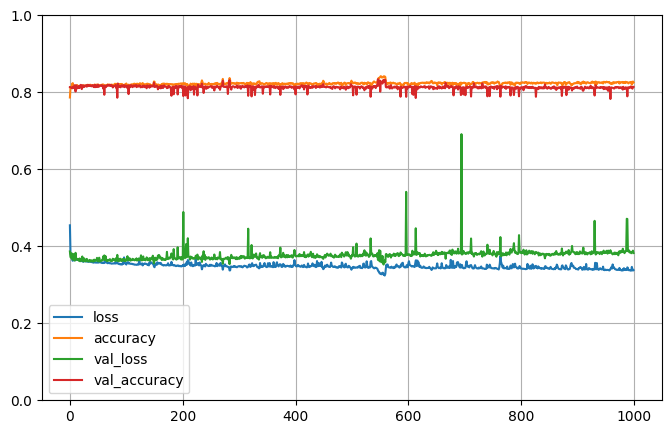

In [19]:
pd.DataFrame(history_NO_EARLY_STOPPING.history).plot(figsize=(8, 5))

plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

ValueError: Filler values must be provided when X has more than 2 training features.

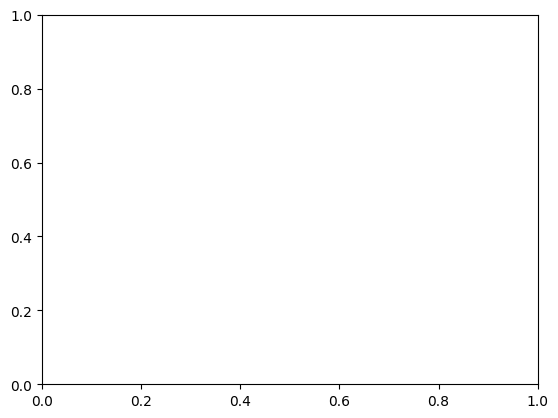

In [21]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test, y_test.astype(np.int_), model_NO_EARLY_STOPPING)
plt.show()

In [ ]:
# model z early stopping patience = 3 ZROBIONY WYZEJ